##  Imports

In [1]:
import os
import sys
from datetime import datetime

import numpy as np
import pandas as pd
import cv2
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn import metrics

import torchvision

from matplotlib import pyplot as plt

In [2]:
from data_handler.FaceMaskData import FaceMaskData
from data_handler.FaceMaskDataset import FaceMaskDataset
from trainer import *
from metrics.metrics import *
from criterion.criterion import *

In [3]:
assert torch.cuda.is_available()

## Configurations

In [60]:
import json
class CFG:
    seed = 42
    model_name = 'faster_rcnn'
    pretrained = True
    img_width = 480
    img_height = 480
    batch_size = 10
    n_epochs = 10
    n_folds = 5
    drop_rate = 0.
    train_size = 0.90
    nms_thresh = 0.2
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    num_workers = 4
    num_classes = 4
    imgs_path = 'images'        #   images dir
    msks_path = 'annotations'   #   annotations dir

    optimizer = optim.SGD
    optimizer_dict = {  'lr':           0.005,
                        'momentum':     0.9,
                        'weight_decay': 0.0005 }
    
    scheduler = optim.lr_scheduler.StepLR
    scheduler_dict = { 'step_size': 2,
                        'gamma':    0.1 }

    def save(path):
        save_path = path + '/model_dict.json'
        with open(save_path, 'w') as f:
            for key, val in CFG.__dict__.items():
                f.write('{}\t\t= {}\n'.format(key, val))

# optimizer = optim.Adam
# optimizer_dict = None
# scheduler = optim.lr_scheduler.StepLR
# scheduler_dict = {    'step_size':   5,
#                       'gamma':        0.1 }

# optimizer = optim.ASGD
# optimizer_dict = None
# scheduler = optim.lr_scheduler.ExponentialLR
# scheduler_dict = { gamma: 0.9 }

np.random.seed(CFG.seed)

# cfg = CFG()

{'__repr__': <slot wrapper '__repr__' of 'type' objects>, '__call__': <slot wrapper '__call__' of 'type' objects>, '__getattribute__': <slot wrapper '__getattribute__' of 'type' objects>, '__setattr__': <slot wrapper '__setattr__' of 'type' objects>, '__delattr__': <slot wrapper '__delattr__' of 'type' objects>, '__init__': <slot wrapper '__init__' of 'type' objects>, '__new__': <built-in method __new__ of type object at 0x55a477f52300>, 'mro': <method 'mro' of 'type' objects>, '__subclasses__': <method '__subclasses__' of 'type' objects>, '__prepare__': <method '__prepare__' of 'type' objects>, '__instancecheck__': <method '__instancecheck__' of 'type' objects>, '__subclasscheck__': <method '__subclasscheck__' of 'type' objects>, '__dir__': <method '__dir__' of 'type' objects>, '__sizeof__': <method '__sizeof__' of 'type' objects>, '__basicsize__': <member '__basicsize__' of 'type' objects>, '__itemsize__': <member '__itemsize__' of 'type' objects>, '__flags__': <member '__flags__' of

## Data Load

Load the data into a dataset

In [5]:
faceMasksData = FaceMaskData(CFG.imgs_path, CFG.msks_path)
(x_train, y_train), (x_test, y_test) = faceMasksData.load_data(
                                                        train_size=CFG.train_size,
                                                        drop_rate=CFG.drop_rate,
                                                        seed=CFG.seed)

print('Training contains {} samples which is {:g}% of the data'.format(len(x_train), len(x_train) * 100 / (len(x_train) + len(x_test))))
print('Testing contains {} samples which is {:g}% of the data'.format(len(x_test), len(x_test) * 100 / (len(x_train) + len(x_test))))

Training contains 767 samples which is 89.9179% of the data
Testing contains 86 samples which is 10.0821% of the data


In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))
    
testset = FaceMaskDataset(x_test, y_test, CFG.imgs_path, CFG.msks_path, CFG.img_width, CFG.img_height, transforms=get_transformer('test'))
test_loader = DataLoader(dataset=testset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, collate_fn=collate_fn)

## Data Exploration

In [7]:
df = pd.read_csv(os.path.join(sys.path[0], 'annotation.csv'))
df.head()

xmin  ymin  xmax  ymax                   name             file  width  \
0    28    55    46    71              with_mask  maksssksksss737    400   
1    98    62   111    78              with_mask  maksssksksss737    400   
2   159    50   193    90  mask_weared_incorrect  maksssksksss737    400   
3   293    59   313    80              with_mask  maksssksksss737    400   
4   352    51   372    72              with_mask  maksssksksss737    400   

   height  class    Xcent     Ycent    boxW      boxH  
0     226      0  0.09250  0.278761  0.0450  0.070796  
1     226      0  0.26125  0.309735  0.0325  0.070796  
2     226      1  0.44000  0.309735  0.0850  0.176991  
3     226      0  0.75750  0.307522  0.0500  0.092920  
4     226      0  0.90500  0.272124  0.0500  0.092920

### Images and labels count

In [8]:
faces = len(df['file'].unique())
annotates = len(df)
print('There are total {} images in the data'.format(faces))
print('There are total {} annotated faces in the data'.format(annotates))
print('Average of {:.5f} per image'.format(annotates/faces))

There are total 853 images in the data
There are total 4072 annotated faces in the data
Average of 4.77374 per image


### Classes Distribution

label count
0              with_mask  3232
1           without_mask   717
2  mask_weared_incorrect   123

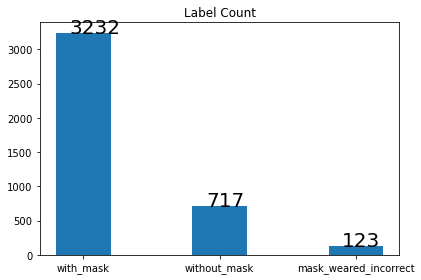

In [9]:
label_df = pd.DataFrame(columns=['label', 'count'])
for k, v in df['name'].value_counts().to_dict().items():
    label_df = label_df.append({'label':k, 'count':v}, ignore_index=True)
    
display(label_df)

fig, ax = plt.subplots()
ax.bar(label_df['label'], label_df['count'], width=0.4)
plt.title('Label Count')
for index, data in enumerate(label_df['count']):
    plt.text(x=index-0.1, y=data+1, s=data , fontdict=dict(fontsize=20))
plt.tight_layout()
plt.show()

### Classes Combinations Distribution

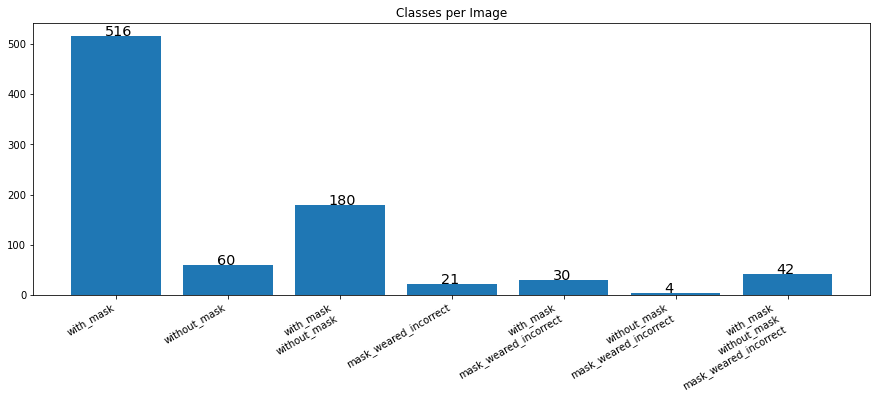

In [10]:
def get_class_distribute(df):
    classes = ["with_mask","without_mask","mask_weared_incorrect"]
    classes_bit_shifter_amount = {
        "with_mask":0,
        "without_mask":1,
        "mask_weared_incorrect":2,
    }
    
    dists = np.zeros(8)
    for name in faceMasksData.images:
        img_name = name.split('.')[0]
        img_classes = df[df['file']==img_name]['name'].unique()
        index = 0
        for cls in img_classes:
            index |= 1 << classes_bit_shifter_amount[cls]
            
        dists[index] += 1
    if dists[0] == 0:
        return dists[1:]
    return dists
            

dist_names = ['None', 'with_mask', 'without_mask', 'with_mask\nwithout_mask',
              'mask_weared_incorrect', 'with_mask\nmask_weared_incorrect',
              'without_mask\nmask_weared_incorrect',
              'with_mask\nwithout_mask\nmask_weared_incorrect']

dist_values = get_class_distribute(df)
if len(dist_values) == 7:
    dist_names = dist_names[1:]

plt.figure(figsize=(15, 5))
axs = plt.bar(dist_names, dist_values)
for ax in axs:
    plt.text(ax.get_xy()[0] + 0.3, ax.get_height(), int(ax.get_height()), fontsize='x-large')
plt.xticks(rotation=30, ha='right')
plt.title('Classes per Image')
plt.show()

We can understand from these two cahrts that the data is very imbalanced.  
For example, there are only 123 faces with an incorrect weared mask, those faces appearing in (21 + 30 + 4 + 42) = 97 images, which is (97 / 853) = 11% of the total data.  
Unlike faces with masks which appearing in (768 / 853) = 90% of the data.  
Therefore, in advanced part of the training, we will have to split the train and validation sets in a good manager.

### Number of Faces per Image

In [11]:
def get_num_faces(df, image_name_col):
    max_faces = find_max_faces(df,image_name_col)
    arr = [0] * (max_faces + 1)
    faces_count =1
    current_img =df.at[0,image_name_col]
    for i in range(1,len(df[1:])):
        if current_img == df.at[i,image_name_col]:
            faces_count = faces_count + 1
        else:
            arr[faces_count] = arr[faces_count] +1
            faces_count =1
            current_img =df.at[i,image_name_col]
    
    df = pd.DataFrame(columns=['faces', 'count'])
    for i, val in enumerate(arr):
        if val > 0:
            df = df.append({'faces': i, 'count': val}, ignore_index=True)
    return df

def find_max_faces(df,image_name_col):
    max_faces=1
    faces_count =1
    current_img =df.at[0,image_name_col]  
    for i in range(1,len(df[1:])):
        if current_img == df.at[i,image_name_col]:
          faces_count = faces_count +1
        else:
            if faces_count > max_faces:
                max_faces = faces_count
            current_img = df.at[i,image_name_col]  
            faces_count =1
    return max_faces

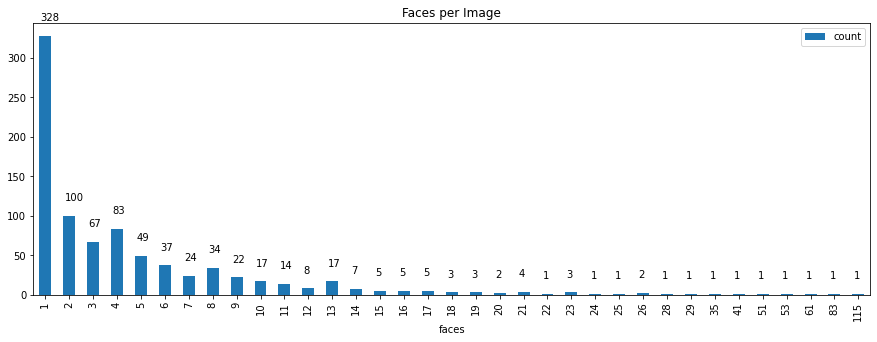

In [12]:
face_dist_df = get_num_faces(df, 'file')

ax = face_dist_df.plot.bar(x='faces', y='count', figsize=(15,5), title='Faces per Image')
for idx, label in enumerate(list(face_dist_df.faces)): 
    val = int(face_dist_df[face_dist_df['faces']==label]['count'])
    ax.annotate(val,
                (idx-0.2, val),
                 xytext=(0, 15), 
                     textcoords='offset points')

In [13]:
print('STD of faces in the images: {:.5}'.format(face_dist_df['count'].std()))

STD of faces in the images: 58.229


### Train Examples

In [14]:
def norm(img):
    img = np.array(img, dtype=np.float32)
    img -= img.min()
    img /= img.max()
    return img

def get_annotated_img(img, annt, is_pred=False):
    img = norm(np.array(np.transpose(img, (1, 2, 0)))) * 255.0  #   multiple by 255 as in the dataset we divide it
                                                                #   needed here because the image come from the dataset in values of [0, 1]
                                                                #   and the annotations are in values of [0, 255] and plt should get images
                                                                #   with values of [0, 1], therefore a normalizing of the images is needed
        
    num_faces = len(annt['boxes'])
    for i in range(num_faces):
        box, cat = annt['boxes'][i], annt['labels'][i]
        if is_pred:
            score = annt['scores'][i]
        xmin, ymin, xmax, ymax = np.array(box, dtype=np.int32)
        start_point = (xmin, ymin)
        end_point = (xmax, ymax)
        
#         [None, 'without_mask','with_mask','mask_weared_incorrect']
        color = (0, 0, 0)
        if cat == 2:
            color = (0, 255, 0) # green
        elif cat == 3:
            color = (0, 0, 255) # blue
        elif cat == 1:
            color = (255, 0, 0) # red
        thickness = 1
        img = cv2.rectangle(img, start_point, end_point, color, thickness)

        font = cv2.FONT_HERSHEY_SIMPLEX
        fontScale = 1 / 3
        if not is_pred:
            img = cv2.putText(img, '{}'.format(faceMasksData.classes[cat]), start_point, font, fontScale, color = (0, 0, 0), thickness=2)
            img = cv2.putText(img, '{}'.format(faceMasksData.classes[cat]), start_point, font, fontScale, color, thickness)
        else:
            img = cv2.putText(img, '{:.2f}'.format(score), start_point, font, fontScale, color = (0, 0, 0), thickness=2)
            img = cv2.putText(img, '{:.2f}'.format(score), start_point, font, fontScale, color, thickness)

        
        
    return img

def show_augmented_samples(dataloader, model=None):    
    samples, annotations = next(iter(dataloader))   #   get the first batch

    amount_samples = min(12, len(samples))          #   number of examples will be at most 12

    for i, (img, ant) in enumerate(zip(samples, annotations)):
        if i >= amount_samples:
            break
        plt.figure(figsize=(10, 10))
#         plt.subplot(amount_samples, 1, i + 1)        
        img = get_annotated_img(img, ant)
        plt.imshow(norm(img))
        plt.axis('off')
        plt.tight_layout()
        plt.show()

# show_augmented_samples(test_loader)

## Training

In [15]:
def get_model(num_classes, pretrained=True):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #   get model
    in_features = model.roi_heads.box_predictor.cls_score.in_features                   #   get input size of last layer
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)         #   regenerate the last layer
    return model

In [16]:
model = get_model(num_classes=CFG.num_classes, pretrained=CFG.pretrained)
# model.roi_heads.fastrcnn_loss = custom_fastrcnn_loss

# torchvision.models.detection.roi_heads.fastrcnn_loss = custom_fastrcnn_loss

In [18]:
datetime_srt = datetime.today().strftime("%d-%m-%y_%H:%M")
run_path = os.path.join(sys.path[0], 'runs', datetime_srt)

In [19]:
CFG.save(run_path)
train(model, x_train, y_train, run_path, CFG)

This running path is: `/home/linuxgpu/anaconda3/envs/lab1/Face-Mask-Detection/runs/05-11-21_18:17`

Fold 1 of 5
Epoch   1 of 10:


train:   0%|          | 0/62 [00:00<?, ?it/s]/home/linuxgpu/anaconda3/envs/lab1/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
valid: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

train:	loss_classifier=12.49317	loss_box_reg=14.76324	loss_objectness=5.32452	loss_rpn_box_reg=1.54166	total loss=34.12259
valid:	loss_classifier=2.25292	loss_box_reg=3.72639	loss_objectness=0.44136	loss_rpn_box_reg=0.26406	total loss=6.68474


Model saved. Loss < PrevLoss (6.68474 < 10000.00000)

Epoch   2 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

train:	loss_classifier=7.50942	loss_box_reg=12.38422	loss_objectness=1.02816	loss_rpn_box_reg=0.86543	total loss=21.78723
valid:	loss_classifier=1.74225	loss_box_reg=3.21130	loss_objectness=0.27300	loss_rpn_box_reg=0.23050	total loss=5.45705


Model saved. Loss < PrevLoss (5.45705 < 6.68474)

Epoch   3 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

train:	loss_classifier=6.13371	loss_box_reg=10.95159	loss_objectness=0.57265	loss_rpn_box_reg=0.71448	total loss=18.37242
valid:	loss_classifier=1.76683	loss_box_reg=2.99464	loss_objectness=0.29395	loss_rpn_box_reg=0.19162	total loss=5.24704


Model saved. Loss < PrevLoss (5.24704 < 5.45705)

Epoch   4 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

train:	loss_classifier=5.39558	loss_box_reg=9.79566	loss_objectness=0.40982	loss_rpn_box_reg=0.61445	total loss=16.21551
valid:	loss_classifier=1.64369	loss_box_reg=2.93214	loss_objectness=0.26669	loss_rpn_box_reg=0.18668	total loss=5.02921


Model saved. Loss < PrevLoss (5.02921 < 5.24704)

Epoch   5 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

train:	loss_classifier=4.71779	loss_box_reg=9.49717	loss_objectness=0.31614	loss_rpn_box_reg=0.58981	total loss=15.12092
valid:	loss_classifier=1.59165	loss_box_reg=2.83864	loss_objectness=0.26982	loss_rpn_box_reg=0.18751	total loss=4.88762


Model saved. Loss < PrevLoss (4.88762 < 5.02921)

Epoch   6 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

train:	loss_classifier=4.14027	loss_box_reg=7.70746	loss_objectness=0.27272	loss_rpn_box_reg=0.47601	total loss=12.59647
valid:	loss_classifier=1.63408	loss_box_reg=2.76256	loss_objectness=0.35790	loss_rpn_box_reg=0.18549	total loss=4.94004


Epoch   7 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.39it/s]

train:	loss_classifier=3.84695	loss_box_reg=7.34216	loss_objectness=0.21235	loss_rpn_box_reg=0.43763	total loss=11.83910
valid:	loss_classifier=1.61335	loss_box_reg=2.76103	loss_objectness=0.38957	loss_rpn_box_reg=0.18690	total loss=4.95085


Epoch   8 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

train:	loss_classifier=3.77559	loss_box_reg=7.14559	loss_objectness=0.18886	loss_rpn_box_reg=0.42466	total loss=11.53470
valid:	loss_classifier=1.60280	loss_box_reg=2.76382	loss_objectness=0.37351	loss_rpn_box_reg=0.18424	total loss=4.92437


Epoch   9 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

train:	loss_classifier=3.69048	loss_box_reg=6.98461	loss_objectness=0.20522	loss_rpn_box_reg=0.42358	total loss=11.30389
valid:	loss_classifier=1.64869	loss_box_reg=2.77338	loss_objectness=0.40438	loss_rpn_box_reg=0.18341	total loss=5.00986


Epoch  10 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=3.63465	loss_box_reg=6.91369	loss_objectness=0.19490	loss_rpn_box_reg=0.41106	total loss=11.15429
valid:	loss_classifier=1.68309	loss_box_reg=2.77379	loss_objectness=0.41103	loss_rpn_box_reg=0.18113	total loss=5.04903


Fold 2 of 5
Epoch   1 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

train:	loss_classifier=4.53494	loss_box_reg=8.36239	loss_objectness=0.42422	loss_rpn_box_reg=0.51501	total loss=13.83655
valid:	loss_classifier=1.18715	loss_box_reg=2.34900	loss_objectness=0.16845	loss_rpn_box_reg=0.18037	total loss=3.88497


Model saved. Loss < PrevLoss (3.88497 < 10000.00000)

Epoch   2 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]

train:	loss_classifier=3.84671	loss_box_reg=7.96371	loss_objectness=0.21968	loss_rpn_box_reg=0.46131	total loss=12.49141
valid:	loss_classifier=1.15595	loss_box_reg=2.42698	loss_objectness=0.08021	loss_rpn_box_reg=0.18742	total loss=3.85056


Model saved. Loss < PrevLoss (3.85056 < 3.88497)

Epoch   3 of 10:


valid: 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]

train:	loss_classifier=3.44012	loss_box_reg=7.19628	loss_objectness=0.17758	loss_rpn_box_reg=0.39760	total loss=11.21158
valid:	loss_classifier=1.22546	loss_box_reg=2.38577	loss_objectness=0.08695	loss_rpn_box_reg=0.18513	total loss=3.88331


Epoch   4 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

train:	loss_classifier=3.08839	loss_box_reg=6.58088	loss_objectness=0.13445	loss_rpn_box_reg=0.34522	total loss=10.14894
valid:	loss_classifier=1.12940	loss_box_reg=2.35025	loss_objectness=0.08231	loss_rpn_box_reg=0.17238	total loss=3.73434


Model saved. Loss < PrevLoss (3.73434 < 3.85056)

Epoch   5 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=2.86524	loss_box_reg=6.05173	loss_objectness=0.11570	loss_rpn_box_reg=0.31792	total loss=9.35059
valid:	loss_classifier=1.19471	loss_box_reg=2.38618	loss_objectness=0.07265	loss_rpn_box_reg=0.19261	total loss=3.84615


Epoch   6 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]

train:	loss_classifier=2.50628	loss_box_reg=4.95412	loss_objectness=0.09104	loss_rpn_box_reg=0.27318	total loss=7.82462
valid:	loss_classifier=1.11048	loss_box_reg=2.30394	loss_objectness=0.07748	loss_rpn_box_reg=0.17992	total loss=3.67183


Model saved. Loss < PrevLoss (3.67183 < 3.73434)

Epoch   7 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

train:	loss_classifier=2.36403	loss_box_reg=4.62358	loss_objectness=0.08497	loss_rpn_box_reg=0.25696	total loss=7.32954
valid:	loss_classifier=1.10005	loss_box_reg=2.27454	loss_objectness=0.07134	loss_rpn_box_reg=0.17652	total loss=3.62245


Model saved. Loss < PrevLoss (3.62245 < 3.67183)

Epoch   8 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

train:	loss_classifier=2.29613	loss_box_reg=4.49001	loss_objectness=0.08401	loss_rpn_box_reg=0.25493	total loss=7.12508
valid:	loss_classifier=1.11251	loss_box_reg=2.29559	loss_objectness=0.07933	loss_rpn_box_reg=0.17565	total loss=3.66307


Epoch   9 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

train:	loss_classifier=2.26208	loss_box_reg=4.42470	loss_objectness=0.08504	loss_rpn_box_reg=0.26506	total loss=7.03688
valid:	loss_classifier=1.10296	loss_box_reg=2.29490	loss_objectness=0.08254	loss_rpn_box_reg=0.17697	total loss=3.65737


Epoch  10 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

train:	loss_classifier=2.19611	loss_box_reg=4.29206	loss_objectness=0.07221	loss_rpn_box_reg=0.24856	total loss=6.80894
valid:	loss_classifier=1.09769	loss_box_reg=2.28760	loss_objectness=0.07405	loss_rpn_box_reg=0.17717	total loss=3.63651


Fold 3 of 5
Epoch   1 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

train:	loss_classifier=2.92817	loss_box_reg=6.42738	loss_objectness=0.14693	loss_rpn_box_reg=0.41855	total loss=9.92103
valid:	loss_classifier=0.67796	loss_box_reg=1.38727	loss_objectness=0.03646	loss_rpn_box_reg=0.09327	total loss=2.19496


Model saved. Loss < PrevLoss (2.19496 < 10000.00000)

Epoch   2 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]

train:	loss_classifier=2.71180	loss_box_reg=6.12645	loss_objectness=0.11343	loss_rpn_box_reg=0.37616	total loss=9.32784
valid:	loss_classifier=0.68707	loss_box_reg=1.67034	loss_objectness=0.03930	loss_rpn_box_reg=0.10620	total loss=2.50292


Epoch   3 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

train:	loss_classifier=2.49826	loss_box_reg=5.85602	loss_objectness=0.10386	loss_rpn_box_reg=0.32545	total loss=8.78359
valid:	loss_classifier=0.60582	loss_box_reg=1.36697	loss_objectness=0.03212	loss_rpn_box_reg=0.08898	total loss=2.09388


Model saved. Loss < PrevLoss (2.09388 < 2.19496)

Epoch   4 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

train:	loss_classifier=2.33197	loss_box_reg=5.65966	loss_objectness=0.09295	loss_rpn_box_reg=0.31696	total loss=8.40155
valid:	loss_classifier=0.63602	loss_box_reg=1.47349	loss_objectness=0.03484	loss_rpn_box_reg=0.09125	total loss=2.23560


Epoch   5 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

train:	loss_classifier=2.22625	loss_box_reg=5.46010	loss_objectness=0.08096	loss_rpn_box_reg=0.30212	total loss=8.06943
valid:	loss_classifier=0.65259	loss_box_reg=1.55161	loss_objectness=0.03763	loss_rpn_box_reg=0.09063	total loss=2.33247


Epoch   6 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.40it/s]

train:	loss_classifier=1.96970	loss_box_reg=4.05503	loss_objectness=0.07201	loss_rpn_box_reg=0.24411	total loss=6.34085
valid:	loss_classifier=0.61869	loss_box_reg=1.28426	loss_objectness=0.04319	loss_rpn_box_reg=0.08540	total loss=2.03155


Model saved. Loss < PrevLoss (2.03155 < 2.09388)

Epoch   7 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

train:	loss_classifier=1.89765	loss_box_reg=3.63823	loss_objectness=0.06854	loss_rpn_box_reg=0.23374	total loss=5.83816
valid:	loss_classifier=0.61967	loss_box_reg=1.25912	loss_objectness=0.03326	loss_rpn_box_reg=0.08333	total loss=1.99538


Model saved. Loss < PrevLoss (1.99538 < 2.03155)

Epoch   8 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

train:	loss_classifier=1.83294	loss_box_reg=3.48046	loss_objectness=0.07422	loss_rpn_box_reg=0.22897	total loss=5.61659
valid:	loss_classifier=0.62169	loss_box_reg=1.25408	loss_objectness=0.04308	loss_rpn_box_reg=0.08428	total loss=2.00312


Epoch   9 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.75561	loss_box_reg=3.29157	loss_objectness=0.07087	loss_rpn_box_reg=0.21681	total loss=5.33485
valid:	loss_classifier=0.62188	loss_box_reg=1.24927	loss_objectness=0.03896	loss_rpn_box_reg=0.08292	total loss=1.99303


Model saved. Loss < PrevLoss (1.99303 < 1.99538)

Epoch  10 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]

train:	loss_classifier=1.76998	loss_box_reg=3.20193	loss_objectness=0.06420	loss_rpn_box_reg=0.21671	total loss=5.25282
valid:	loss_classifier=0.61406	loss_box_reg=1.26824	loss_objectness=0.04156	loss_rpn_box_reg=0.08395	total loss=2.00781


Fold 4 of 5
Epoch   1 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

train:	loss_classifier=2.05243	loss_box_reg=4.41513	loss_objectness=0.09707	loss_rpn_box_reg=0.27926	total loss=6.84389
valid:	loss_classifier=0.46161	loss_box_reg=1.33160	loss_objectness=0.01409	loss_rpn_box_reg=0.05777	total loss=1.86506


Model saved. Loss < PrevLoss (1.86506 < 10000.00000)

Epoch   2 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]

train:	loss_classifier=2.01326	loss_box_reg=4.82177	loss_objectness=0.09690	loss_rpn_box_reg=0.29505	total loss=7.22698
valid:	loss_classifier=0.48010	loss_box_reg=1.11389	loss_objectness=0.01718	loss_rpn_box_reg=0.05964	total loss=1.67081


Model saved. Loss < PrevLoss (1.67081 < 1.86506)

Epoch   3 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]

train:	loss_classifier=1.91575	loss_box_reg=4.38664	loss_objectness=0.08998	loss_rpn_box_reg=0.27383	total loss=6.66621
valid:	loss_classifier=0.50085	loss_box_reg=1.13023	loss_objectness=0.01712	loss_rpn_box_reg=0.05962	total loss=1.70782


Epoch   4 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

train:	loss_classifier=2.00507	loss_box_reg=4.64460	loss_objectness=0.09803	loss_rpn_box_reg=0.28962	total loss=7.03731
valid:	loss_classifier=0.50979	loss_box_reg=1.26189	loss_objectness=0.01567	loss_rpn_box_reg=0.06422	total loss=1.85158


Epoch   5 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

train:	loss_classifier=1.81968	loss_box_reg=4.26812	loss_objectness=0.07208	loss_rpn_box_reg=0.26446	total loss=6.42433
valid:	loss_classifier=0.47413	loss_box_reg=1.04761	loss_objectness=0.01574	loss_rpn_box_reg=0.06327	total loss=1.60075


Model saved. Loss < PrevLoss (1.60075 < 1.67081)

Epoch   6 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.42it/s]

train:	loss_classifier=1.62290	loss_box_reg=3.19021	loss_objectness=0.05291	loss_rpn_box_reg=0.21897	total loss=5.08499
valid:	loss_classifier=0.45217	loss_box_reg=0.89457	loss_objectness=0.01302	loss_rpn_box_reg=0.05576	total loss=1.41552


Model saved. Loss < PrevLoss (1.41552 < 1.60075)

Epoch   7 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.51678	loss_box_reg=2.83347	loss_objectness=0.06154	loss_rpn_box_reg=0.19728	total loss=4.60907
valid:	loss_classifier=0.43347	loss_box_reg=0.88919	loss_objectness=0.01637	loss_rpn_box_reg=0.05606	total loss=1.39510


Model saved. Loss < PrevLoss (1.39510 < 1.41552)

Epoch   8 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.49789	loss_box_reg=2.65566	loss_objectness=0.05668	loss_rpn_box_reg=0.18809	total loss=4.39832
valid:	loss_classifier=0.43327	loss_box_reg=0.87659	loss_objectness=0.01534	loss_rpn_box_reg=0.05548	total loss=1.38067


Model saved. Loss < PrevLoss (1.38067 < 1.39510)

Epoch   9 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.46804	loss_box_reg=2.55507	loss_objectness=0.05772	loss_rpn_box_reg=0.18930	total loss=4.27013
valid:	loss_classifier=0.44194	loss_box_reg=0.87230	loss_objectness=0.01241	loss_rpn_box_reg=0.05497	total loss=1.38162


Epoch  10 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]

train:	loss_classifier=1.45445	loss_box_reg=2.48446	loss_objectness=0.04824	loss_rpn_box_reg=0.18395	total loss=4.17109
valid:	loss_classifier=0.43687	loss_box_reg=0.86098	loss_objectness=0.01981	loss_rpn_box_reg=0.05475	total loss=1.37241


Model saved. Loss < PrevLoss (1.37241 < 1.38067)

Fold 5 of 5
Epoch   1 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

train:	loss_classifier=1.62273	loss_box_reg=3.38877	loss_objectness=0.05946	loss_rpn_box_reg=0.24876	total loss=5.31973
valid:	loss_classifier=0.36072	loss_box_reg=0.78967	loss_objectness=0.01670	loss_rpn_box_reg=0.02711	total loss=1.19419


Model saved. Loss < PrevLoss (1.19419 < 10000.00000)

Epoch   2 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

train:	loss_classifier=1.69089	loss_box_reg=3.84252	loss_objectness=0.06960	loss_rpn_box_reg=0.31393	total loss=5.91694
valid:	loss_classifier=0.35703	loss_box_reg=0.83312	loss_objectness=0.00687	loss_rpn_box_reg=0.02655	total loss=1.22357


Epoch   3 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

train:	loss_classifier=1.67083	loss_box_reg=3.86955	loss_objectness=0.07501	loss_rpn_box_reg=0.27311	total loss=5.88849
valid:	loss_classifier=0.36270	loss_box_reg=0.81295	loss_objectness=0.01311	loss_rpn_box_reg=0.03257	total loss=1.22133


Epoch   4 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

train:	loss_classifier=1.61588	loss_box_reg=3.72399	loss_objectness=0.06980	loss_rpn_box_reg=0.26176	total loss=5.67143
valid:	loss_classifier=0.35309	loss_box_reg=0.76394	loss_objectness=0.00871	loss_rpn_box_reg=0.02840	total loss=1.15414


Model saved. Loss < PrevLoss (1.15414 < 1.19419)

Epoch   5 of 10:


valid: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]

train:	loss_classifier=1.59628	loss_box_reg=3.59831	loss_objectness=0.05693	loss_rpn_box_reg=0.26269	total loss=5.51421
valid:	loss_classifier=0.37400	loss_box_reg=0.73586	loss_objectness=0.01268	loss_rpn_box_reg=0.03027	total loss=1.15281


Model saved. Loss < PrevLoss (1.15281 < 1.15414)

Epoch   6 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

train:	loss_classifier=1.39459	loss_box_reg=2.64283	loss_objectness=0.06257	loss_rpn_box_reg=0.21232	total loss=4.31231
valid:	loss_classifier=0.34748	loss_box_reg=0.61645	loss_objectness=0.00645	loss_rpn_box_reg=0.02437	total loss=0.99474


Model saved. Loss < PrevLoss (0.99474 < 1.15281)

Epoch   7 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.37406	loss_box_reg=2.33562	loss_objectness=0.05657	loss_rpn_box_reg=0.19122	total loss=3.95747
valid:	loss_classifier=0.32767	loss_box_reg=0.60212	loss_objectness=0.00458	loss_rpn_box_reg=0.02343	total loss=0.95780


Model saved. Loss < PrevLoss (0.95780 < 0.99474)

Epoch   8 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.32035	loss_box_reg=2.17660	loss_objectness=0.04999	loss_rpn_box_reg=0.17633	total loss=3.72327
valid:	loss_classifier=0.33740	loss_box_reg=0.60616	loss_objectness=0.00644	loss_rpn_box_reg=0.02334	total loss=0.97334


Epoch   9 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.27149	loss_box_reg=2.06843	loss_objectness=0.06334	loss_rpn_box_reg=0.17044	total loss=3.57370
valid:	loss_classifier=0.32357	loss_box_reg=0.59305	loss_objectness=0.00530	loss_rpn_box_reg=0.02325	total loss=0.94517


Model saved. Loss < PrevLoss (0.94517 < 0.95780)

Epoch  10 of 10:


valid: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

train:	loss_classifier=1.26126	loss_box_reg=1.98724	loss_objectness=0.05697	loss_rpn_box_reg=0.16960	total loss=3.47507
valid:	loss_classifier=0.32799	loss_box_reg=0.58212	loss_objectness=0.00608	loss_rpn_box_reg=0.02317	total loss=0.93936


Model saved. Loss < PrevLoss (0.93936 < 0.94517)



In [20]:
# run_path = os.path.join(sys.path[0], 'runs', '01-11-21_17:19')
# print(run_path)

In [21]:
# model_path = os.path.join(run_path, 'models', 'faster_rcnn_model.pth')
# model = get_model(4)
# model.load_state_dict(torch.load(model_path))

In [22]:
map_writer = SummaryWriter('{}/logs/mAP'.format(run_path))

## Evaluation

### Examples

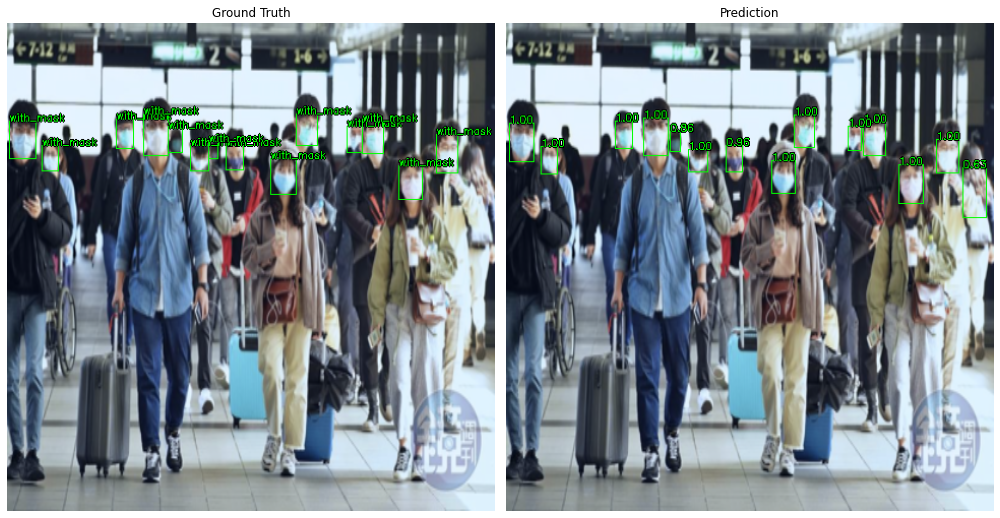

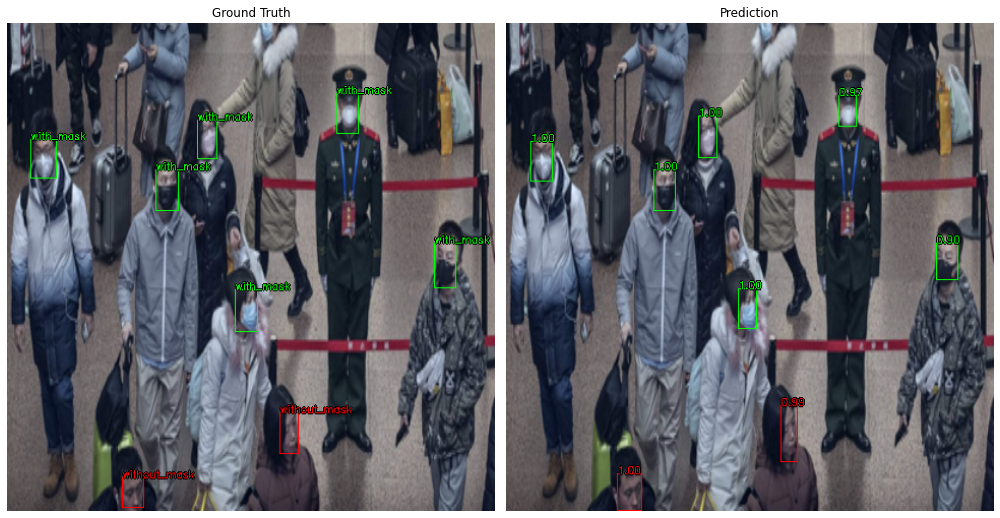

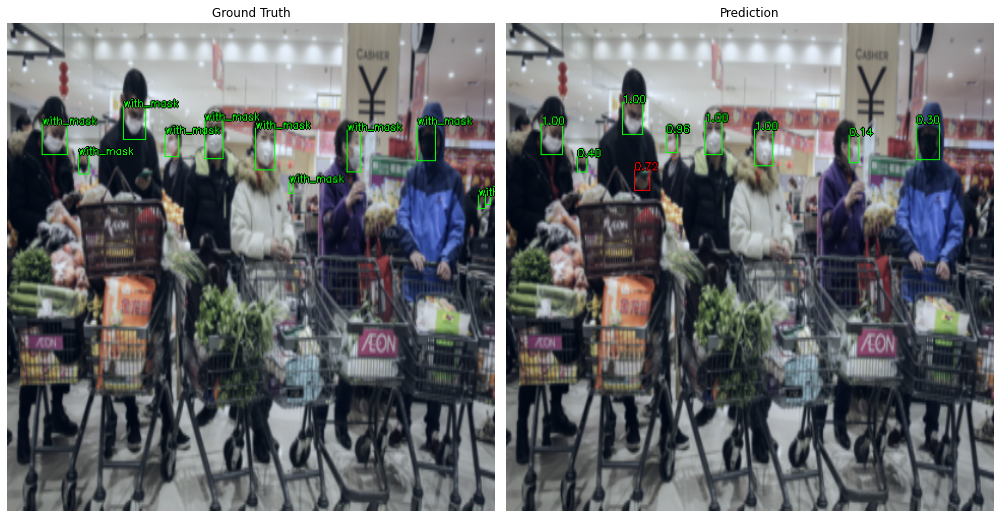

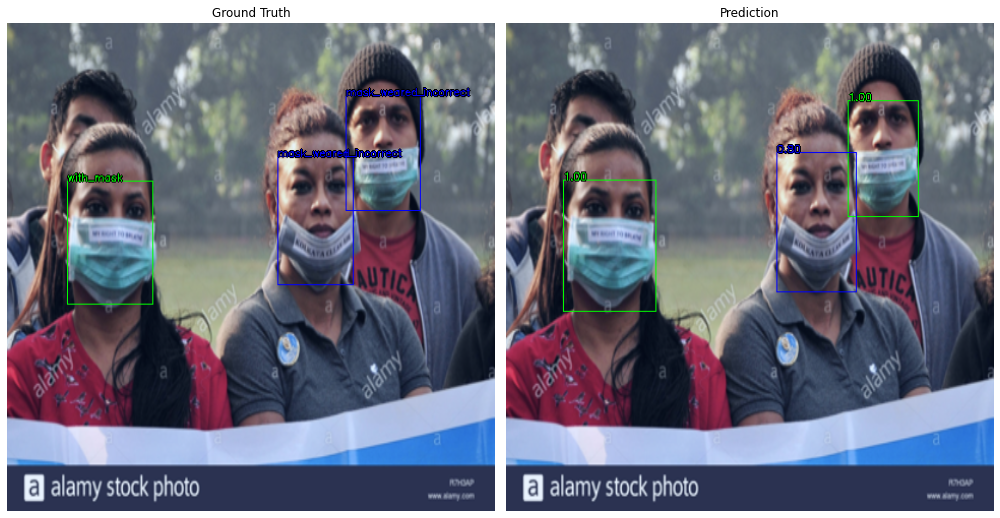

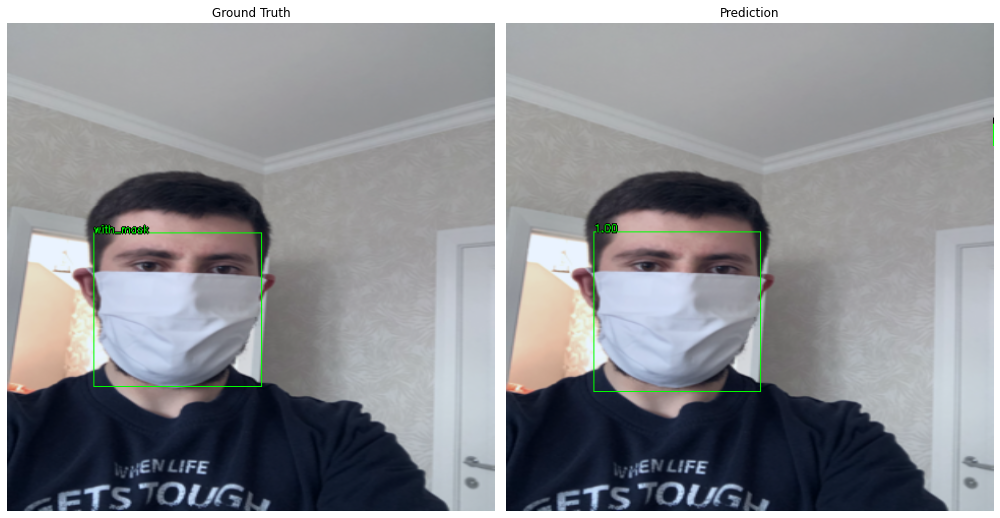

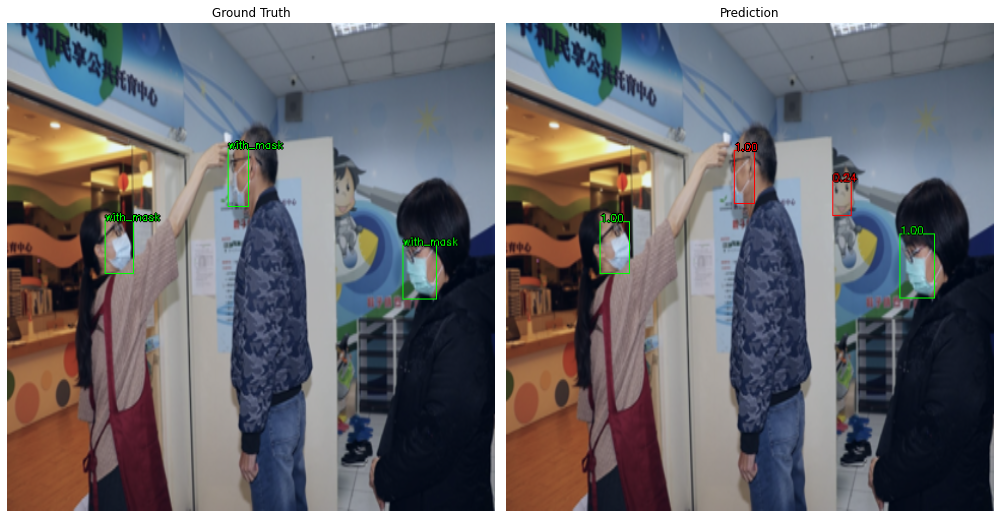

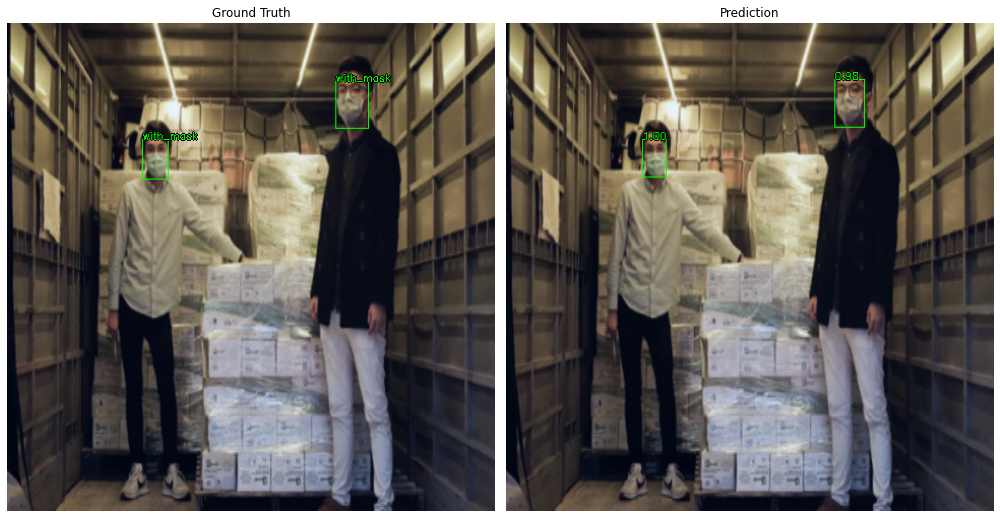

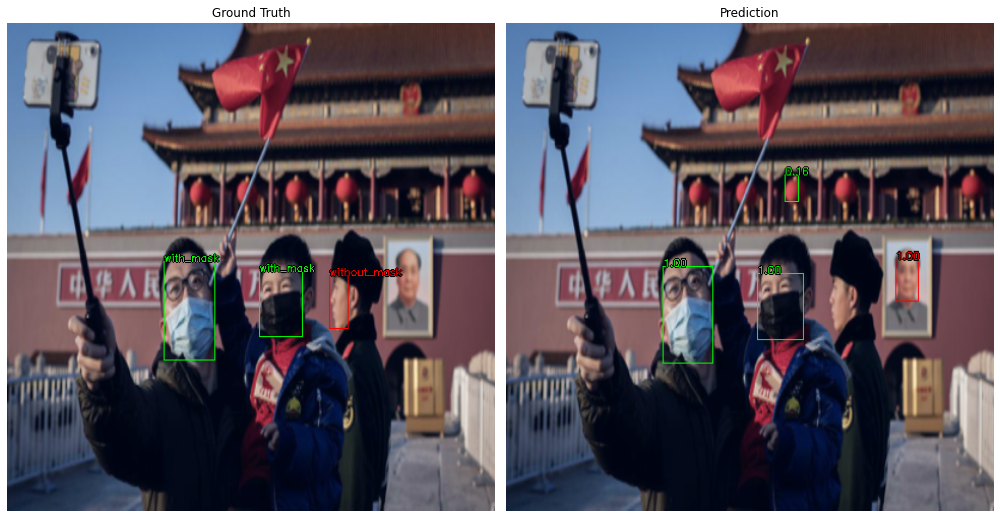

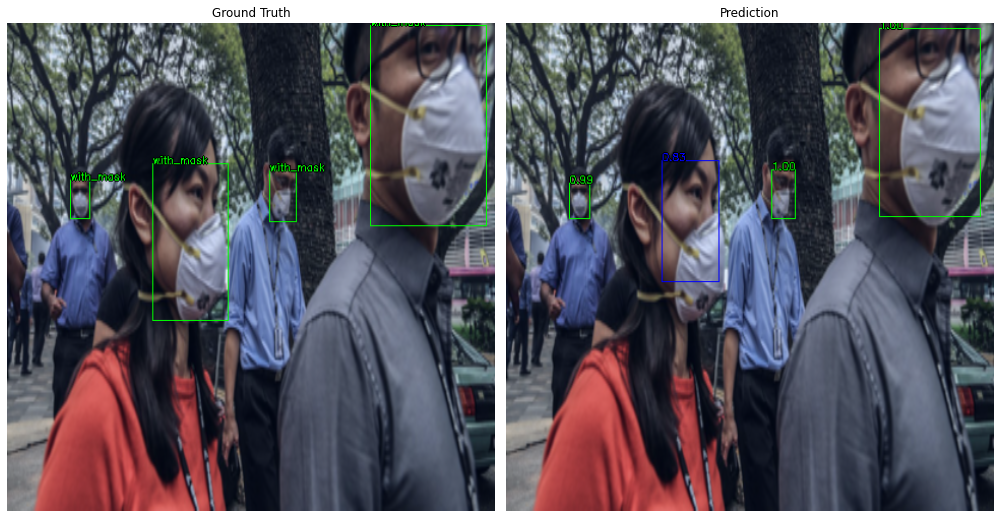

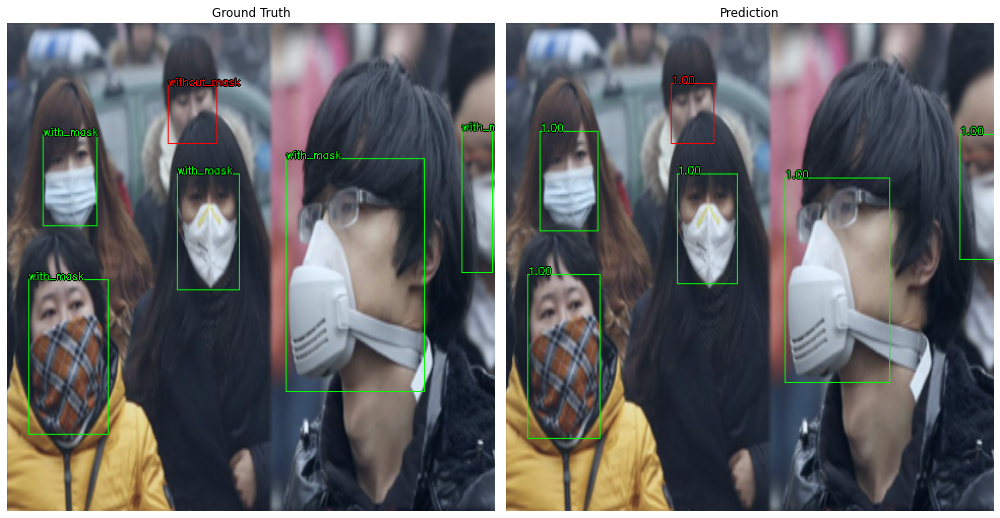

In [23]:
def plot_test_examples(model, loader, nms_threshold):
    device = CFG.device
    model = model.to(device).eval()

    imgs, annts = next(iter(loader))
    imgs  = list(img.to(device) for img in imgs)

    output = model(imgs)

    amount_samples = min(12, len(imgs))          #   number of examples will be at most 12

    for i, (img, ant, pred) in enumerate(zip(imgs, annts, output)):
        if i >= amount_samples:
            break
            
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 60))

        axes[0].set_title('Ground Truth')
        axes[1].set_title('Prediction')

        axes[0].axis('off')
        axes[1].axis('off')

        annot_img = get_annotated_img(img.cpu().detach().numpy(), ant)
        axes[0].imshow(norm(annot_img))          

        pred_thrs = get_pred_by_threshold(pred, nms_threshold)
        pred_cpu = {k: v.cpu().detach().numpy() for k, v in pred_thrs.items()}
        
        annot_img = get_annotated_img(img.cpu().detach().numpy(), pred_cpu, is_pred=True)
        axes[1].imshow(norm(annot_img))  

        fig.tight_layout()
        plt.show()

    del imgs, pred, pred_thrs, pred_cpu
    torch.cuda.empty_cache()

plot_test_examples(model, test_loader, nms_threshold=0.2)

### mAP@[0.5:0.05:0.95]

In [24]:
def plot_precision_recall(df, iou_thresh, save_path=None):
    
    auc_dict = dict()
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25, 7))
    plt.title('IOU Threshold {:.3f}'.format(iou_thresh))
    
    for idx, c in enumerate(df['real_class'].unique()):
        
        prec = df[df['real_class']==c]['precision']
        recall = df[df['real_class']==c]['recall']
        
        auc = metrics.auc(x=recall, y=prec)
        auc_dict[c] = auc
        axes[idx].plot(recall, prec)
        axes[idx].set_title('Class {} AP={:.5f}'.format(faceMasksData.classes[c], auc))
        axes[idx].grid()
        axes[idx].set_ylabel('Precision')
        axes[idx].set_xlabel('Recall')
        
    fig.tight_layout()
    plt.show()

    if save_path:
        fig.savefig('{}/AP@{:.3}.png'.format(save_path, iou_thresh))
    
    return auc_dict

In [25]:
def plot_mAP_graph(iou_dict, save_path=None, iou_start=0.5, iou_step=0.05, iou_end=0.95):
    x, y = zip(*sorted(iou_dict.items()))

    fig = plt.figure(figsize=(25, 7))
    plt.title('mAP Vs. IoU Threshold')
    plt.plot(x, y, marker='o')
    plt.tight_layout()
    plt.grid()
    plt.show()

    save_path = '{}/mAP@[{:.3}:{:.3}:{:.3}].png'.format(save_path, iou_start, iou_step, iou_end)
    fig.savefig(save_path)

evaluating IoU: 100%|██████████| 9/9 [00:08<00:00,  1.05it/s]


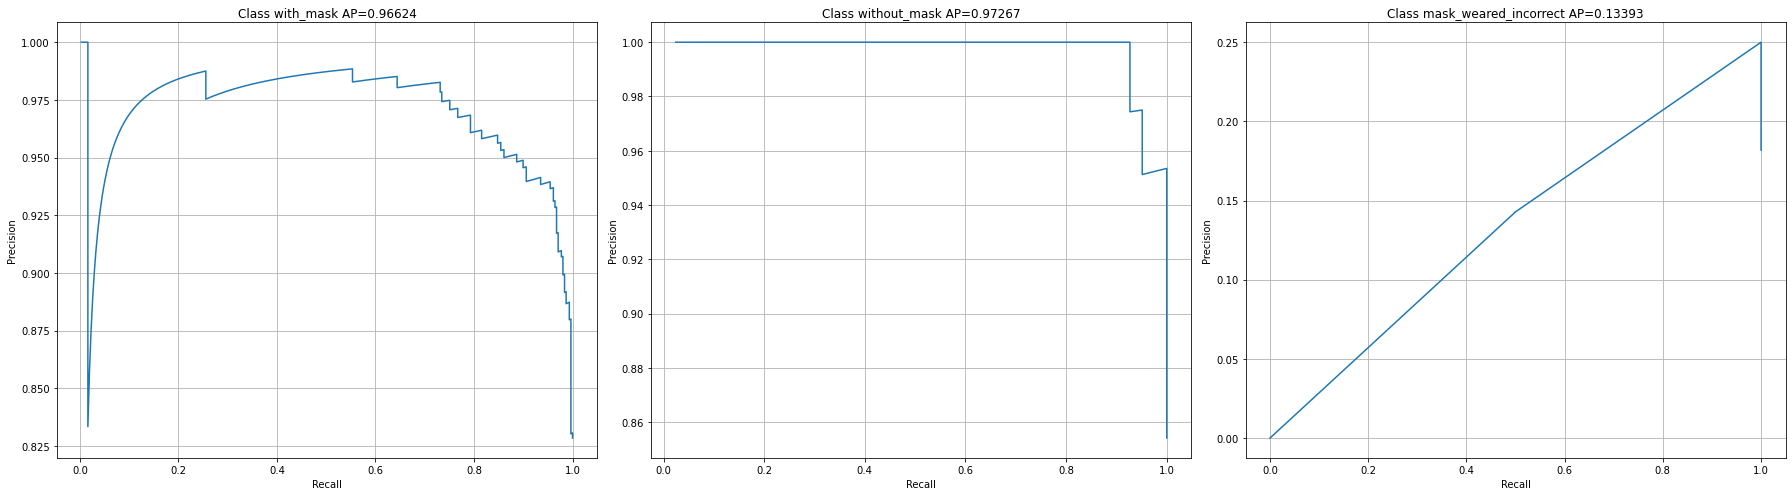

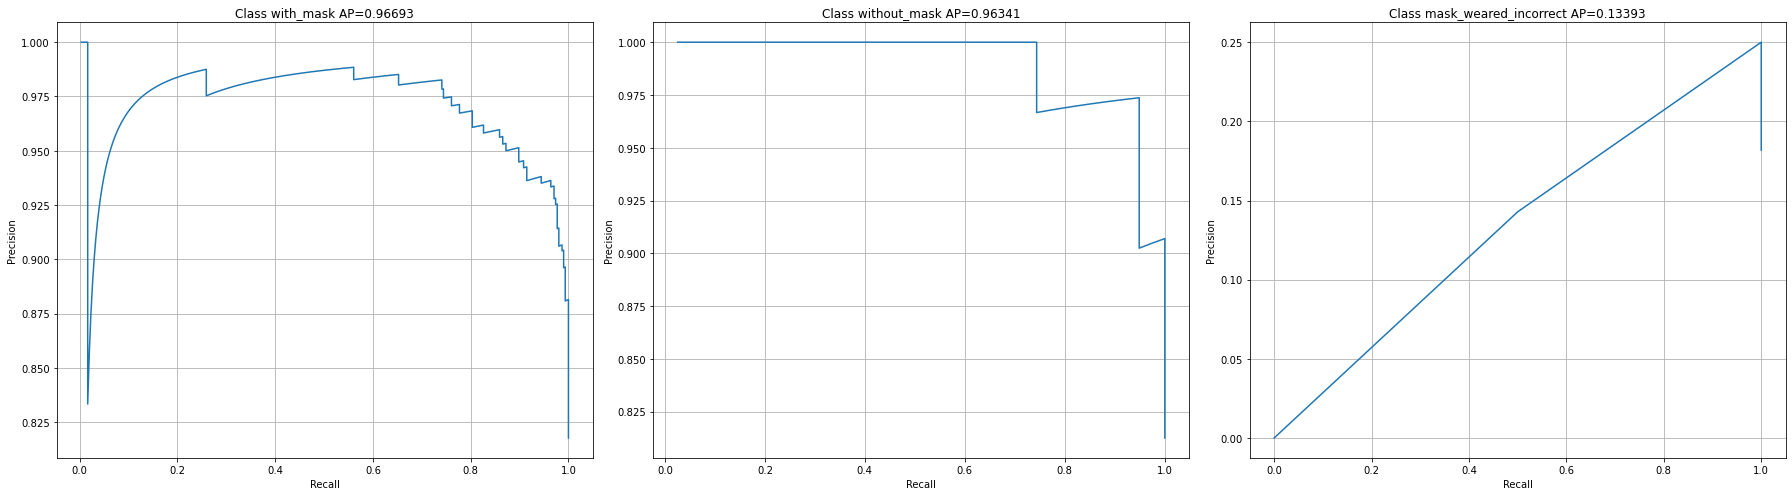

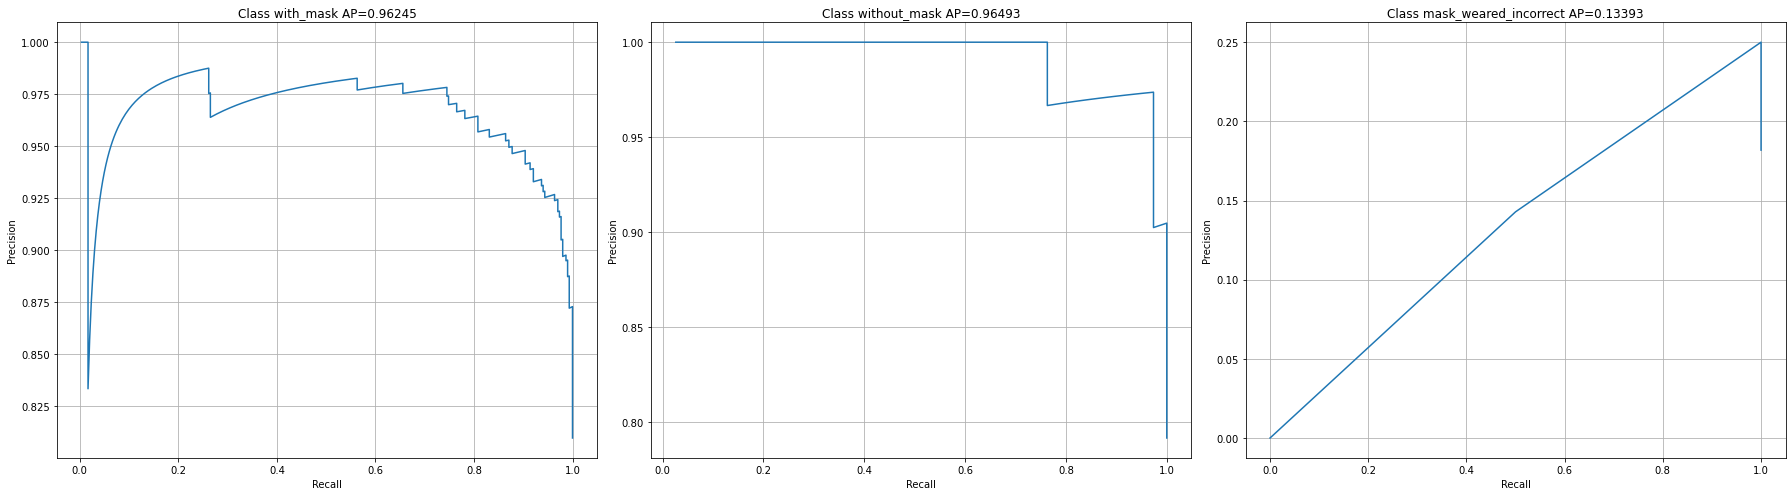

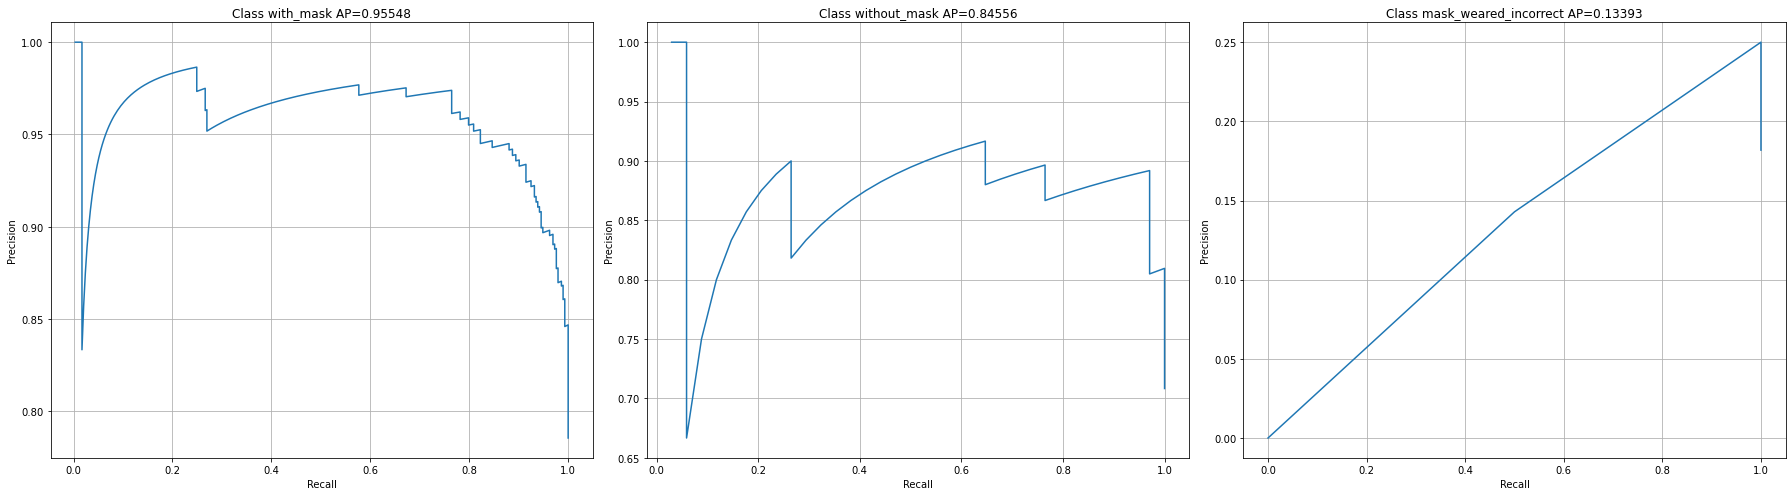

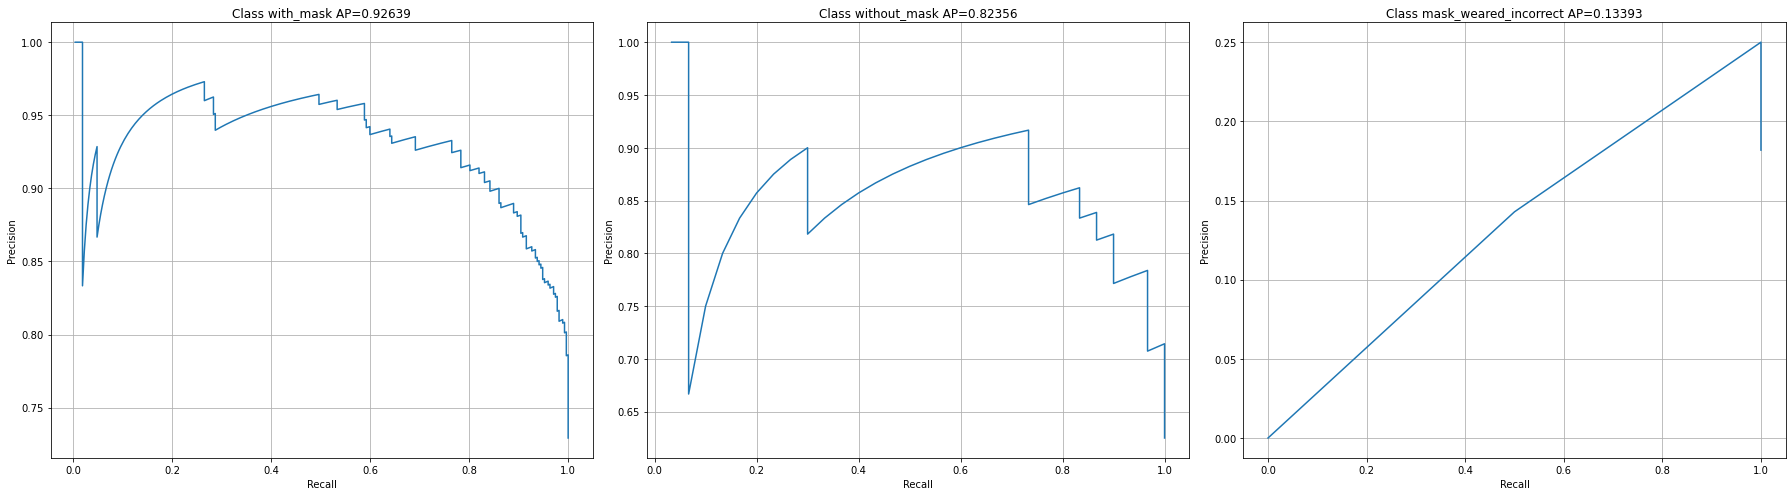

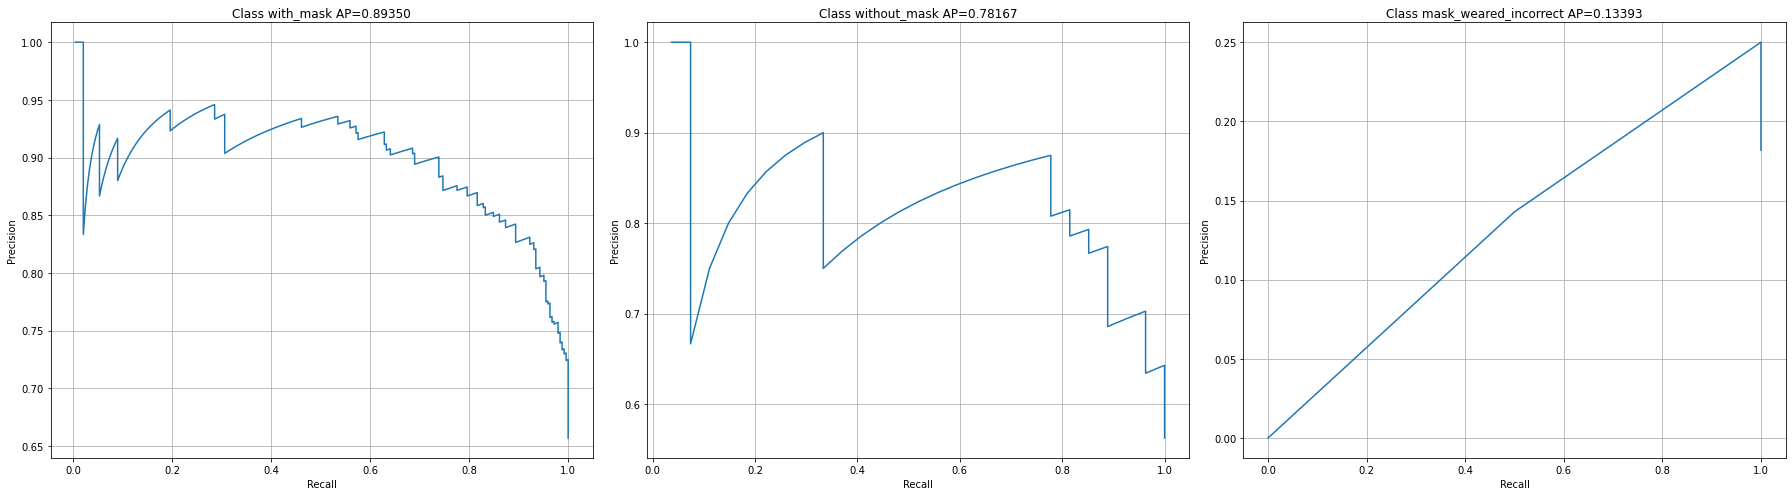

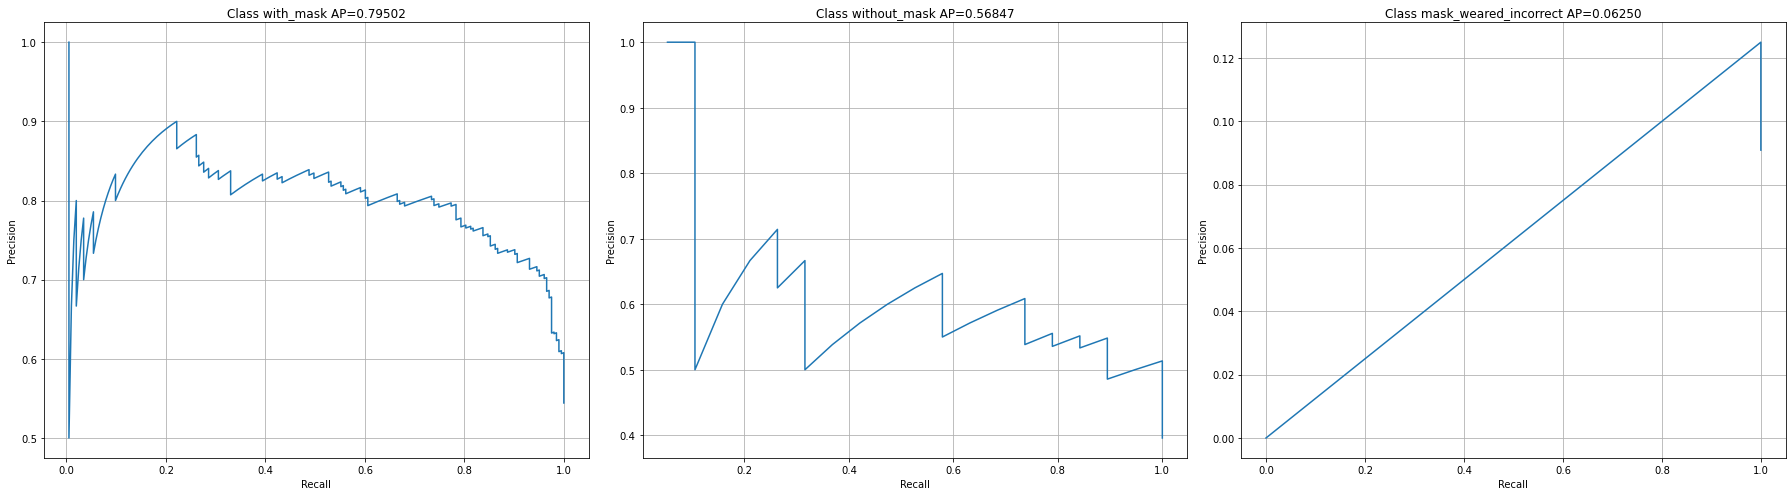

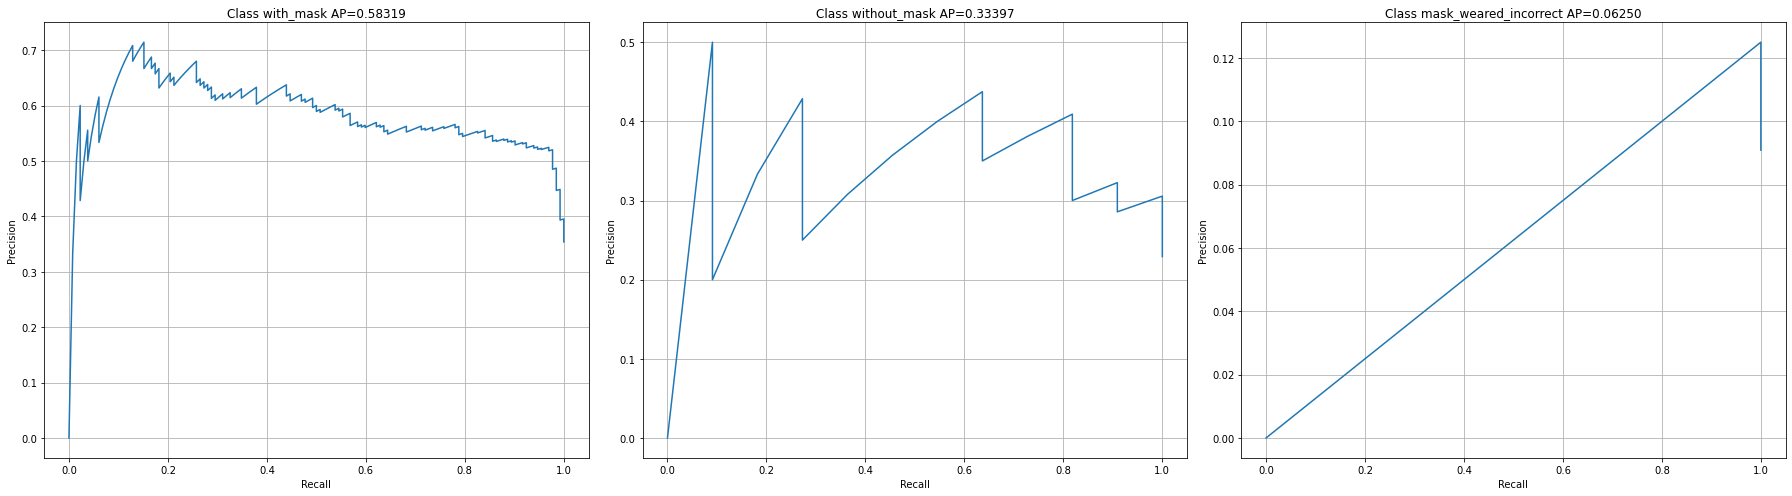

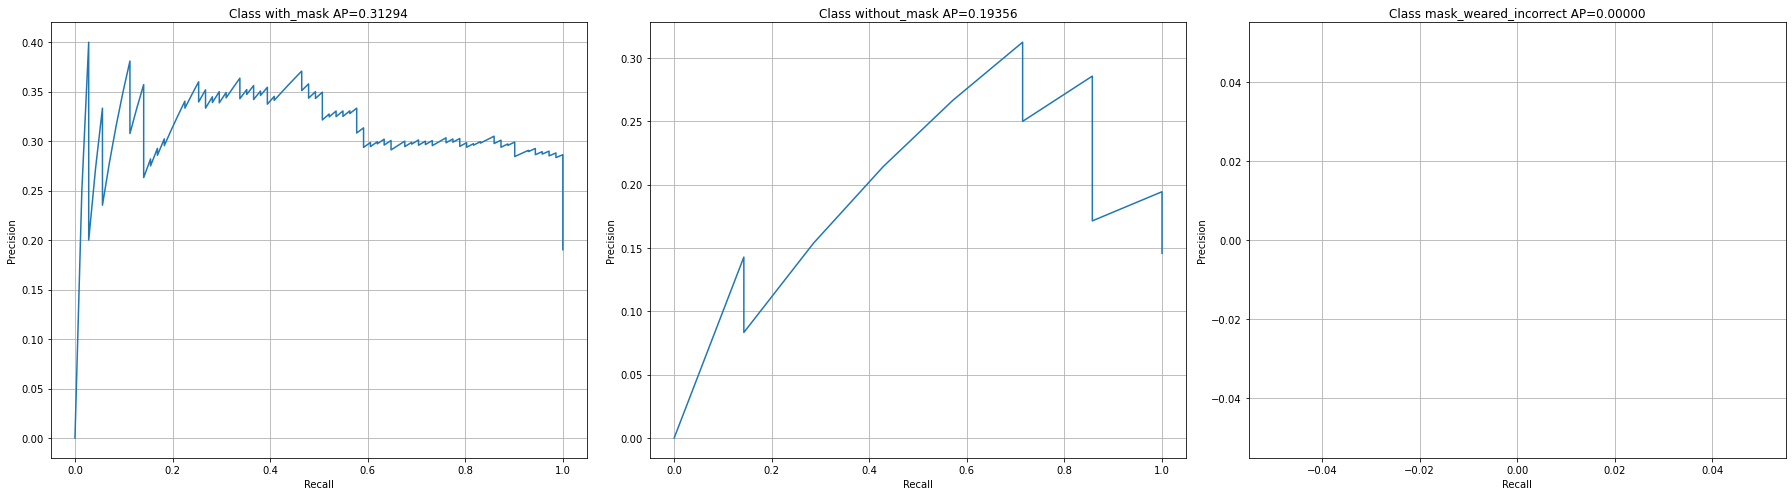

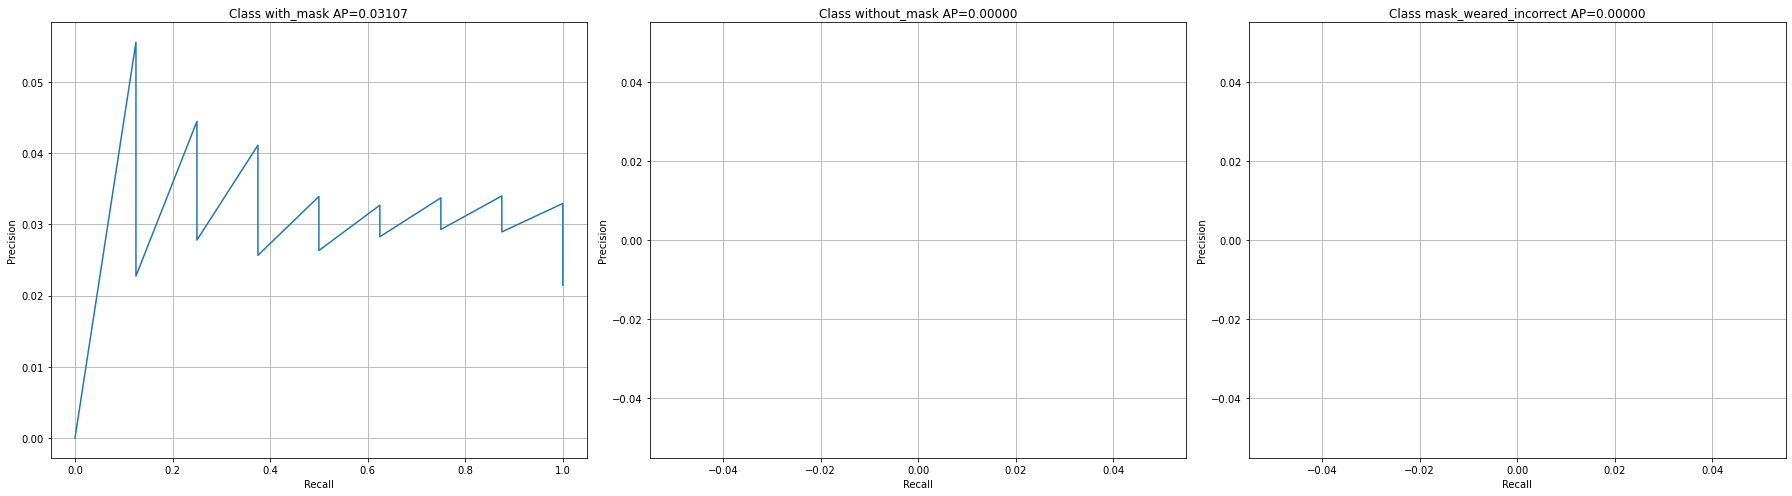

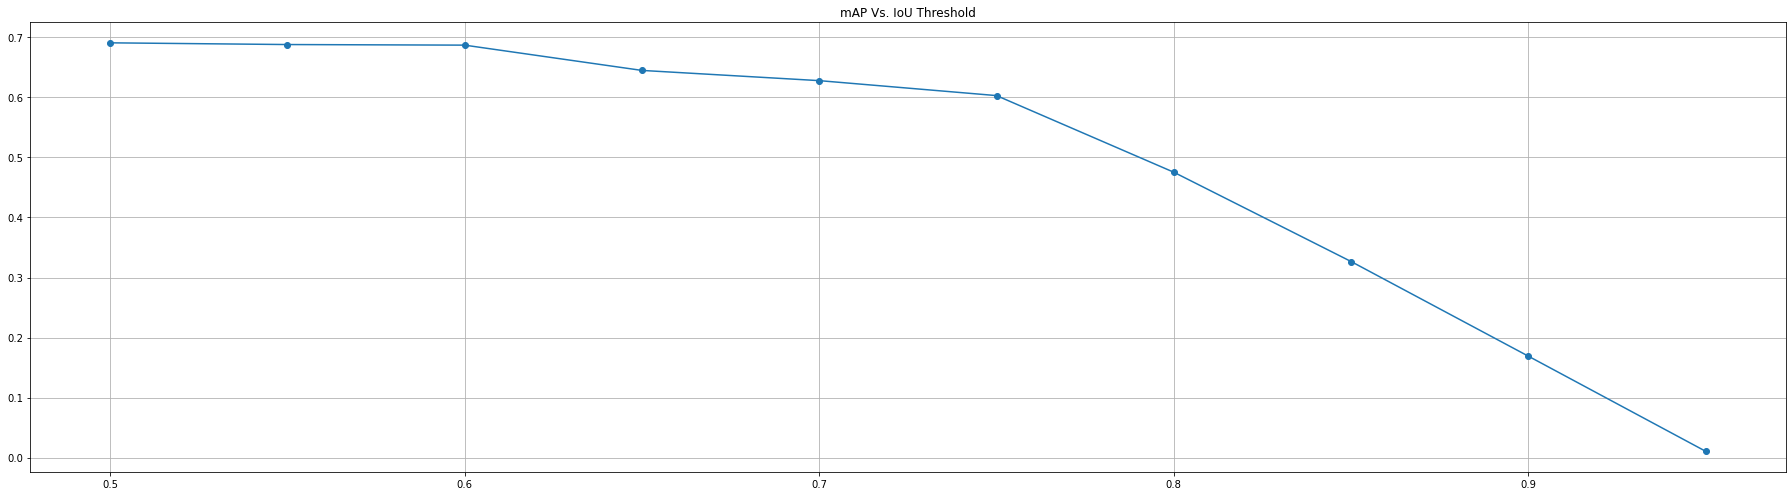

mAP@0.5 =	0.69095
mAP@0.55 =	0.68809
mAP@0.6 =	0.6871
mAP@0.65 =	0.64499
mAP@0.7 =	0.62796
mAP@0.75 =	0.60304
mAP@0.8 =	0.47533
mAP@0.85 =	0.32655
mAP@0.9 =	0.16883
mAP@0.95 =	0.010358

mAP Per Class:
with_mask		mAP@[0.5:0.05:0.95] =	0.73932
without_mask		mAP@[0.5:0.05:0.95] =	0.64478
mask_weared_incorrect		mAP@[0.5:0.05:0.95] =	0.09286
Total mAP@[0.5:0.05:0.95] =	0.49232


In [26]:
def evaluate(model, loader, nms_thresh, iou_start=0.5, iou_step=0.05, iou_end=0.95, eps=1e-6):
       
    metrics_path = '{}/metrics'.format(run_path)
    df = get_iou_as_df(model, loader, nms_thresh)
    auc_dict = dict()
    
    for iou_trsh in np.arange(iou_start, iou_end + iou_step, iou_step):
        
        df = calc_precision_recall(df, iou_trsh, metrics_path)
        auc_dict[iou_trsh] = plot_precision_recall(df, iou_trsh, metrics_path)
    
    iou_dict = calc_mAP_from_auc_dict(auc_dict)
    classes_mAP = calc_mAP_per_class(auc_dict, iou_dict)

    plot_mAP_graph(iou_dict, metrics_path, iou_start, iou_step, iou_end)
    
    total_mAP = .0
    for iou in iou_dict:
        print('mAP@{:.3} =\t{:.5}'.format(iou, iou_dict[iou]))
    print('\nmAP Per Class:')
    for c, val in classes_mAP.items():
        total_mAP += val
        print('{}\t\tmAP@[0.5:0.05:0.95] =\t{:.5f}'.format(faceMasksData.classes[c], classes_mAP[c]))
    total_mAP /= len(classes_mAP)
    print('Total mAP@[0.5:0.05:0.95] =\t{:.5f}'.format(total_mAP))

evaluate(model, test_loader, CFG.nms_thresh)